In [ ]:
# Télécharger le dataset Imagenette
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xvzf imagenette2-320.tgz

# Assurez-vous que le chemin est correct
data_dir = "./imagenette2-320"


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
imagenette2-320/train/n03888257/n03888257_16077.JPEG
imagenette2-320/train/n03888257/n03888257_23339.JPEG
imagenette2-320/train/n03888257/n03888257_44204.JPEG
imagenette2-320/train/n03888257/n03888257_61633.JPEG
imagenette2-320/train/n03888257/n03888257_15067.JPEG
imagenette2-320/train/n03888257/n03888257_75365.JPEG
imagenette2-320/train/n03888257/n03888257_63966.JPEG
imagenette2-320/train/n03888257/n03888257_3927.JPEG
imagenette2-320/train/n03888257/n03888257_20684.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-320/train/n03888257/n03888257_14016.JPEG
imagenette2-320/train/n03888257/n03888257_37776.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-320/train/n03888257/n03888257_17513.JPEG
imagenette2-320/train/n03888257/n03888257_17143.JPEG
imagenette2-320/train/n03888257/n03888257_6738.JPEG
imagenette2-320/train/n03888257/n03888257_4355.JPEG
imagenet

Training the model...
Epoch [1/1], Loss: 1.8657

Testing the model on adversarial examples...
Accuracy on adversarial examples: 21.17%
Average confidence: 44.72%

Visualizing an example...


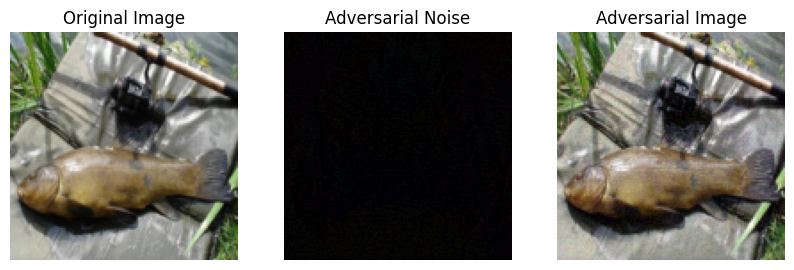

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Charger le dataset Imagenette
def load_imagenette(data_dir="./imagenette2-320", image_size=128, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Générer des exemples adversariaux avec FGSM
def FGSM(model, images, labels, epsilon):
    images = images.clone().detach().requires_grad_(True)

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = torch.clamp(images + perturbation, 0, 1)
    return adversarial_images, perturbation

# Réseau neuronal profond
class DeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Entraîner le modèle
def train_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Tester le modèle
def test_model(model, loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    confidences = []

    for images, labels in loader:
        adv_images, perturbation = FGSM(model, images, labels, epsilon)
        outputs = model(adv_images)
        probabilities = nn.Softmax(dim=1)(outputs)
        confidence, predictions = probabilities.max(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        confidences.extend(confidence.tolist())

    accuracy = 100 * correct / total
    avg_confidence = np.mean(confidences)
    print(f"Accuracy on adversarial examples: {accuracy:.2f}%")
    print(f"Average confidence: {avg_confidence * 100:.2f}%")
    return accuracy, avg_confidence

# Visualiser l'image, le bruit et l'image perturbée
def visualize_images(images, perturbation, adversarial_images):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(perturbation[0].cpu().numpy(), (1, 2, 0)), cmap='gray')
    plt.title("Adversarial Noise")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(adversarial_images[0].detach().cpu().numpy(), (1, 2, 0)))
    plt.title("Adversarial Image")
    plt.axis("off")

    plt.show()

# Fonction principale
def main():
    data_dir = "./imagenette2-320"
    image_size = 128
    batch_size = 64
    epsilon = 0.025
    epochs = 1

    train_loader, test_loader = load_imagenette(data_dir, image_size, batch_size)

    model = DeepCNN(num_classes=len(train_loader.dataset.classes))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Training the model...")
    train_model(model, train_loader, optimizer, epochs)

    print("\nTesting the model on adversarial examples...")
    accuracy, avg_confidence = test_model(model, test_loader, epsilon)

    print("\nVisualizing an example...")
    images, labels = next(iter(test_loader))
    adversarial_images, perturbation = FGSM(model, images, labels, epsilon)
    visualize_images(images, perturbation, adversarial_images)

if __name__ == "__main__":
    main()
